In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch import nn
import numpy as np
import pandas as pd
from datasets import load_metric
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [4]:
model_name = "dkleczek/Polish-Hate-Speech-Detection-Herbert-Large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [32]:
hate_speech_classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Data processing

In [33]:
train_df = pd.read_csv('hate_train.csv')
train_df.head()

,sentence,label
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


In [34]:
import re
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
link_pattern = re.compile(r'^https?:\/\/.*[\r\n]*', flags=re.MULTILINE)

patterns = [emoji_pattern, link_pattern]
to_remove = ['@anonymized_account', '#', 'RT', '//', '\\']

In [35]:
def filter_sentence(text):
    for remove in to_remove:
        text = text.replace(remove, "")
    for pattern in patterns:
        text = pattern.sub(r'', text)
    text = " ".join(text.split())
    return text

In [36]:
train_df['sentence'] = train_df['sentence'].apply(filter_sentence)

# Removing duplicates
bool_series = train_df.duplicated(keep='first')
train_df = train_df[~bool_series]
train_df['sentence']

0        Dla mnie faworytem do tytułu będzie Cracovia. ...
1               Brawo ty Daria kibic ma być na dobre i złe
2        Super, polski premier składa kwiaty na grobach...
3                              Musi. Innej drogi nie mamy.
4          Odrzut natychmiastowy, kwaśna mina, mam problem
                               ...                        
10036                           Ty zagrasz? Nie wiedziałem
10037    A VAR nie miał poprawić jakości sędziowania, t...
10038            Szanowany, bo kolega ładnie go pożegnał ?
10039    A kto inny ma się bić? Każdy zwyciezca ligi wo...
10040                 A wróżbita Maciej mówi że zrozumiemy
Name: sentence, Length: 9531, dtype: object

<AxesSubplot:>

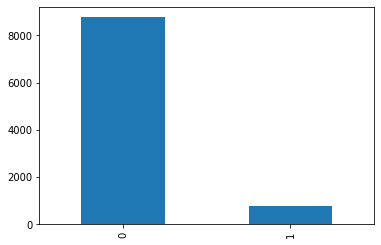

In [37]:
train_df.label.value_counts().plot.bar()

In [38]:
train_data, eval_data, train_targets, eval_targets = train_test_split(train_df['sentence'].values, train_df['label'].values, test_size=0.2)

In [7]:
def tokenize_function(in_data):
    return tokenizer(in_data, padding=True, truncation=True)

In [40]:
train_tokenized = tokenize_function(list(train_data))
eval_tokenized = tokenize_function(list(eval_data))

In [41]:
class MyDataset(Dataset):
    def __init__(self, tokenized_data, targets):
        self.tokenized_data = tokenized_data
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        temp = {key: torch.tensor(val[idx]) for key, val in self.tokenized_data.items()}
        temp['label'] = torch.tensor(self.targets[idx])
        return temp

In [42]:
def get_class_weights():
    return compute_class_weight(class_weight='balanced', classes=np.unique(train_df['label']), y=train_df['label'])

In [43]:
print(get_class_weights())

[0.54388268 6.1970091 ]


In [44]:
train_dataset = MyDataset(train_tokenized, train_targets)
eval_dataset = MyDataset(eval_tokenized, eval_targets)

In [45]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=50)
eval_dataloader = DataLoader(eval_dataset, batch_size=40)

In [46]:
def get_accuracy(model):
    y_true = []
    y_pred = []

    metric= load_metric("accuracy")
    model.eval()
    for batch in eval_dataloader:
        labels = batch["label"].to(device)
        y_true.extend(labels.cpu().numpy())
        batch = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}

        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        y_pred.extend(predictions.cpu().numpy())
        metric.add_batch(predictions=predictions, references=labels)

    return metric.compute()['accuracy'], y_true, y_pred

In [47]:
# We just want to train classifier
for param in hate_speech_classifier.parameters():
    param.requires_grad = False
for param in hate_speech_classifier.classifier.parameters():
    param.requires_grad = True

In [48]:
def train_model(model, loss_fun, optimizer):
    num_epochs = 20

    model.to(device)
    for epoch in range(num_epochs):
        losses = []
        for batch in train_dataloader:

            labels = batch["label"].to(device)
            batch = {"attention_mask": batch['attention_mask'].to(device), "input_ids": batch['input_ids'].to(device)}
            outputs = model(**batch)
            loss = loss_fun(outputs.logits, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        print(f'EPOCH {epoch+1}/{num_epochs} | Loss: {np.mean(losses)}; Accuracy: {get_accuracy(model)[0]:.3f}%')

In [49]:
optimizer = Adam(hate_speech_classifier.parameters(), lr=3e-4)
loss_fun = nn.CrossEntropyLoss()
train_model(model=hate_speech_classifier, loss_fun=loss_fun, optimizer=optimizer)

Loss: 0.1942225095931611; Accuracy: 0.921%
Loss: 0.18756346355855855; Accuracy: 0.922%
Loss: 0.18412613428009103; Accuracy: 0.919%
Loss: 0.18205233497752082; Accuracy: 0.927%
Loss: 0.18120665595032812; Accuracy: 0.922%
Loss: 0.17893652165052937; Accuracy: 0.926%
Loss: 0.17839764621035725; Accuracy: 0.919%
Loss: 0.17797874805389666; Accuracy: 0.919%
Loss: 0.17564468626298158; Accuracy: 0.927%
Loss: 0.1750432652439557; Accuracy: 0.926%
Loss: 0.1766344108466619; Accuracy: 0.926%
Loss: 0.17505770459089404; Accuracy: 0.921%
Loss: 0.17414814288563588; Accuracy: 0.926%
Loss: 0.17302799146938946; Accuracy: 0.922%
Loss: 0.17272340662144367; Accuracy: 0.927%
Loss: 0.17209555853913033; Accuracy: 0.924%
Loss: 0.1715058814125513; Accuracy: 0.927%
Loss: 0.17163487706406444; Accuracy: 0.922%
Loss: 0.17183729716473156; Accuracy: 0.917%
Loss: 0.17095364128647286; Accuracy: 0.916%


In [50]:
target_names = ['no_hate', 'hate']
acc, y_true, y_pred = get_accuracy(hate_speech_classifier)
print(f'Model accuracy: {acc:.3f}%')
print(classification_report(y_true, y_pred, target_names=target_names))

Model accuracy: 0.916%
              precision    recall  f1-score   support

     no_hate       0.96      0.95      0.95      1757
        hate       0.47      0.48      0.47       150

    accuracy                           0.92      1907
   macro avg       0.71      0.72      0.71      1907
weighted avg       0.92      0.92      0.92      1907



In [51]:
torch.save(hate_speech_classifier.state_dict(), 'hate_classifier.pt')

# Model training with weighting of classes

In [52]:
class_weights = torch.Tensor(get_class_weights()).to(device)
loss_fun = nn.CrossEntropyLoss(weight=class_weights)
hate_speech_classifier_weighed = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

for param in hate_speech_classifier_weighed.parameters():
    param.requires_grad = False
for param in hate_speech_classifier_weighed.classifier.parameters():
    param.requires_grad = True

del hate_speech_classifier
train_model(model=hate_speech_classifier_weighed, loss_fun=loss_fun, optimizer=optimizer)

Loss: 0.4394223175309842; Accuracy: 0.859%
Loss: 0.4381807320842556; Accuracy: 0.859%
Loss: 0.43382783360730587; Accuracy: 0.859%
Loss: 0.4289470615437607; Accuracy: 0.859%
Loss: 0.4356796189266093; Accuracy: 0.859%
Loss: 0.43887415820477055; Accuracy: 0.859%
Loss: 0.43634427109964535; Accuracy: 0.859%
Loss: 0.43893883674362905; Accuracy: 0.859%
Loss: 0.43475082750413935; Accuracy: 0.859%
Loss: 0.4345809753034629; Accuracy: 0.859%
Loss: 0.43506951766466; Accuracy: 0.859%
Loss: 0.4333746119651919; Accuracy: 0.859%
Loss: 0.44753553645283567; Accuracy: 0.859%
Loss: 0.4424666325543441; Accuracy: 0.859%
Loss: 0.4374623817750831; Accuracy: 0.859%
Loss: 0.44237711402325847; Accuracy: 0.859%
Loss: 0.43310075219160593; Accuracy: 0.859%
Loss: 0.4327468056889141; Accuracy: 0.859%
Loss: 0.444519359107111; Accuracy: 0.859%
Loss: 0.441435529905207; Accuracy: 0.859%


In [53]:
acc, y_true, y_pred = get_accuracy(hate_speech_classifier_weighed)
print(f'Model accuracy: {acc:.3f}%')
print(classification_report(y_true, y_pred, target_names=target_names))

Model accuracy: 0.859%
              precision    recall  f1-score   support

     no_hate       0.97      0.88      0.92      1757
        hate       0.31      0.67      0.43       150

    accuracy                           0.86      1907
   macro avg       0.64      0.77      0.67      1907
weighted avg       0.92      0.86      0.88      1907



In [54]:
torch.save(hate_speech_classifier_weighed.state_dict(), 'hate_classifier_weighed.pt')
del hate_speech_classifier_weighed

In [5]:
hate_speech_classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
hate_speech_classifier_weighed = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
hate_speech_classifier.load_state_dict(torch.load('hate_classifier.pt'))
hate_speech_classifier_weighed.load_state_dict(torch.load('hate_classifier_weighed.pt'))

<All keys matched successfully>

In [17]:
text = 'Kocham cię'

tokenized_text = tokenize_function(text)
inputs_ids = tokenized_text['input_ids']
attention_mask = tokenized_text['attention_mask']

batch = {'attention_mask': torch.tensor([attention_mask]), "input_ids": torch.tensor([inputs_ids])}
with torch.no_grad():
    result = hate_speech_classifier(**batch).logits
    prediction = torch.argmax(result, dim=-1)
print(f'Without class weights: {result[0].cpu().numpy()}. Prediction: {prediction.item()}')
with torch.no_grad():
    result = hate_speech_classifier_weighed(**batch).logits
    prediction = torch.argmax(result, dim=-1)
print(f'With class weights: {result[0].cpu().numpy()}. Prediction: {prediction.item()}')

Without class weights: [ 2.1572924 -2.315198 ]. Prediction: 0
With class weights: [ 1.4175406 -1.5756836]. Prediction: 0
